In [1]:
import torch
import pytorch_lightning as pl
from protoclr_obow import PCLROBoW
from feature_extractors import feature_extractor
from omegaconf import OmegaConf
OmegaConf.register_new_resolver("uuid", lambda : "123")
from dataloaders import UnlabelledDataset, UnlabelledDataModule
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import os
import h5py
import numpy as np
from PIL import Image
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import einops
sns.set_theme()
%matplotlib inline
%load_ext autoreload

In [2]:
pl.seed_everything(72)

Global seed set to 72


72

In [3]:
import sys

In [4]:
sys.modules["bow.feature_extractor"] = feature_extractor # to load properly from pickles

In [5]:
%autoreload 2

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [7]:
from sklearn.manifold import TSNE

In [8]:
ckpt_path = "ckpts/cnn.ckpt"

In [9]:
model = PCLROBoW.load_from_checkpoint(ckpt_path)

MultiHeadDotProduct


/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [10]:
from save_features import LabelledDataset, save_features

In [11]:
conf = OmegaConf.load("configs/local/edge.yml")["data"]

In [12]:
train_classes = ["n02687172", "n04251144", "n02823428", "n03676483", "n03400231"]
test_classes = ["n03272010", "n07613480", "n03775546", "n03127925", "n04146614"]
trainset = LabelledDataset('miniimagenet', conf["datapath"],
                           'train', train_classes)
testset = LabelledDataset('miniimagenet', conf["datapath"],
                          'test', test_classes)
trainloader = DataLoader(trainset, shuffle=False, batch_size=100)
testloader = DataLoader(testset, shuffle=False, batch_size=100)

In [13]:
fe = save_features(model.feature_extractor, trainloader, "onlycnn.hdf5")

0/30
10/30
20/30


In [14]:
_ = save_features(model, trainloader, "cnn_gnn.hfd5", gnn=torch.load(ckpt_path, map_location=device), prev_out=fe)

In [15]:
fe = save_features(model.feature_extractor, testloader, "Test_onlycnn.hdf5")

0/30
10/30
20/30


In [16]:
_ = save_features(model, testloader, "Test_cnn_gnn.hfd5", gnn=torch.load(ckpt_path, map_location=device), prev_out=fe)

## Plots

In [17]:
f_train_cnn = h5py.File('onlycnn.hdf5', 'r')
f_test_cnn = h5py.File('Test_onlycnn.hdf5', 'r')

In [18]:
X_cnn_5_train = f_train_cnn['all_feats']
y_cnn_5_train = f_train_cnn['all_labels']
X_cnn_5_test = f_test_cnn['all_feats']
y_cnn_5_test = f_test_cnn['all_labels']

In [19]:
import random
import warnings

In [20]:
train_protoclr_idx = random.sample(range(len(y_cnn_5_train)),500)
train_protoclr_idx.sort()

X_cnn_5_train = X_cnn_5_train[train_protoclr_idx]
y_cnn_5_train = y_cnn_5_train[train_protoclr_idx]

test_protoclr_idx = random.sample(range(len(y_cnn_5_test)),500)
test_protoclr_idx.sort()

X_cnn_5_test = X_cnn_5_test[test_protoclr_idx]
y_cnn_5_test = y_cnn_5_test[test_protoclr_idx]

In [21]:
um = TSNE(n_components=2, random_state=0)
X_cnn_2d_train = um.fit_transform(einops.rearrange(X_cnn_5_train, "b c h w -> b (c h w)"))

/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [22]:
um = TSNE(n_components=2, random_state=0)
X_cnn_2d_test = um.fit_transform(einops.rearrange(X_cnn_5_test, "b c h w -> b (c h w)"))

/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [23]:
def plot2d(X_2d, y,colors=None, title=None, save_as=None):
    target_ids = range(5)
    labels_train = ["Class {}".format(i) for i in range(1,6)]

    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(11.7,8.27))
    ax = fig.add_subplot(111)
    #colors = 'r', 'g', 'b', 'c', 'm'#, 'y', 'k', 'w', 'orange', 'purple'
    
    markers = "o","D","*","^","P"
    #print(len(colors))
    for i, c, label, marker in zip(target_ids, colors, labels_train, markers):
        ax.scatter(X_2d[y == i, 0],
                   X_2d[y == i, 1], 
                   c=c, label=label, marker=marker)
    #plt.legend()
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(left=True, bottom=True)
    #plt.legend(loc='lower right')
    if save_as:
        plt.savefig(save_as, bbox_inches = 'tight',
            pad_inches = 0)
    if title:
        plt.title(title)
    plt.show()

In [24]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [25]:
sns.set_theme()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

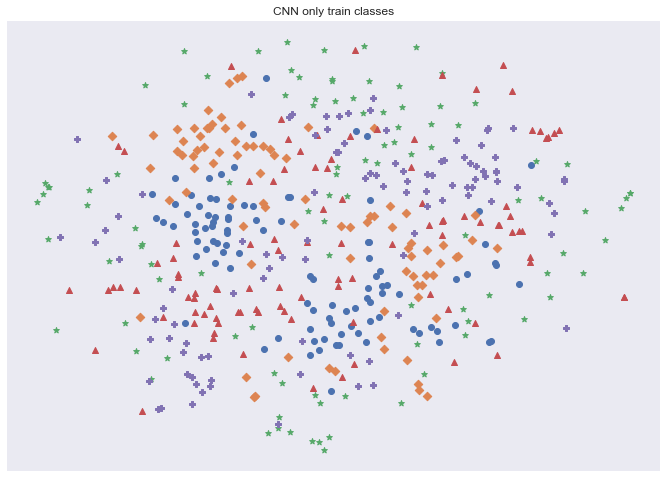

In [26]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot2d(X_2d=X_cnn_2d_train, 
           y=y_cnn_5_train,
           colors=colors[:5],
           title="CNN only train classes")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

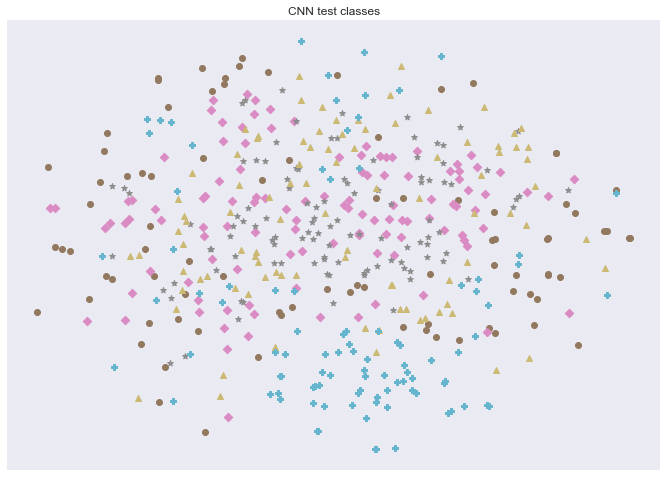

In [27]:
plot2d(X_2d=X_cnn_2d_test, 
       y=y_cnn_5_test,
       colors=colors[5:],
       title="CNN test classes")

In [28]:
f_train_cnn_gnn = h5py.File('cnn_gnn.hfd5', 'r')
f_test_cnn_gnn = h5py.File('Test_cnn_gnn.hfd5', 'r')

In [29]:
X_cnn_gnn_5_train = f_train_cnn_gnn['all_feats']
y_cnn_gnn_5_train = f_train_cnn_gnn['all_labels']
X_cnn_gnn_5_test = f_test_cnn_gnn['all_feats']
y_cnn_gnn_5_test = f_test_cnn_gnn['all_labels']

In [30]:
train_protoclr_idx = random.sample(range(len(y_cnn_gnn_5_train)),500)
train_protoclr_idx.sort()

X_cnn_gnn_5_train = X_cnn_gnn_5_train[train_protoclr_idx]
y_cnn_gnn_5_train = y_cnn_gnn_5_train[train_protoclr_idx]

test_protoclr_idx = random.sample(range(len(y_cnn_gnn_5_test)),500)
test_protoclr_idx.sort()

X_cnn_gnn_5_test = X_cnn_gnn_5_test[test_protoclr_idx]
y_cnn_gnn_5_test = y_cnn_gnn_5_test[test_protoclr_idx]

In [31]:
um = TSNE(n_components=2, random_state=0)
X_cnn_gnn_2d_train = um.fit_transform(X_cnn_gnn_5_train)

/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [32]:
um = TSNE(n_components=2, random_state=0)
X_cnn_gnn_2d_test = um.fit_transform(X_cnn_gnn_5_test)

/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

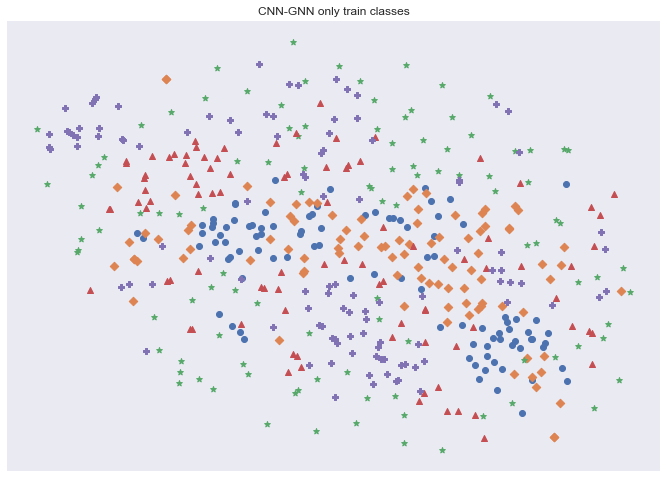

In [33]:
plot2d(X_2d=X_cnn_gnn_2d_train, 
       y=y_cnn_gnn_5_train,
       colors=colors[:5],
       title="CNN-GNN only train classes")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

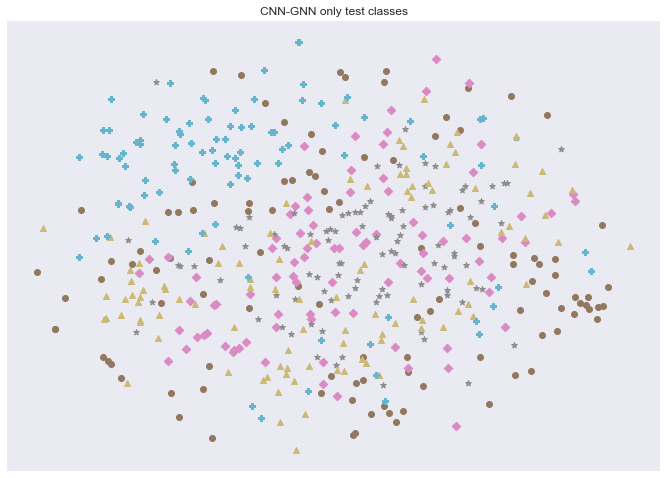

In [34]:
plot2d(X_2d=X_cnn_gnn_2d_test, 
       y=y_cnn_gnn_5_test,
       colors=colors[5:],
       title="CNN-GNN only test classes")